# Image Classification using Kitti object detection dataset

Import Tensorflow, Keras and OpenCV libraries:

In [2]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

import tensorflow_hub as hub
import tensorflow_datasets as tfds

from tensorflow.keras import layers

import keras_cv
import cv2
import os
import numpy

import logging
logger = tf.get_logger()
logger.setLevel(logging.ERROR)

2024-03-13 15:20:06.266452: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-03-13 15:20:08.260899: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


Using TensorFlow backend


### Transform object-detection dataset to image classification dataset (helper functions)

Load Kitti dataset and transform into train, test and validation datasets with corect box coordinates.

In [2]:
def transform_and_save_dataset(dataset, shape, type, name):
       
    def cut_image(image, box, shape):
        h,w,ch = image.shape
        ymin, xmin, ymax, xmax = box
        ymin, xmin, ymax, xmax = h-int(ymin*h), int(xmin*w), h-int(ymax*h), int(xmax*w)                
        object = image[ymax:ymin, xmin:xmax, :]
        
        if object.shape[1]==0 or object.shape[0]==0:                
            testimage = np.copy(image)
            cv2.rectangle(
                testimage,
                (xmax, ymax),
                (xmin, ymin),
                (255, 0, 0, 0.5),
                4
            )
            keras_cv.visualization.plot_image_gallery(
                np.array([testimage]), rows=1, cols=1, value_range=(0, 255), show=True, scale=4)
        object = tf.image.resize(object, shape)
        return object

    counter = 0
    while len(dataset)>0:
        new_images = []
        new_labels = []
    
        for el in dataset.take(100):
            # print(el)
            isCarAdded = False
            # print(el['image/file_name'])
            # print(el["objects"]["type"])
            image = el["image"]
            boxes = el["objects"]["bbox"]
            classes = el["objects"]["type"]
            for box, label in zip(boxes, classes):    
                if not isCarAdded or label!=0:
                    new_labels.append(label)
                    new_images.append(cut_image(image, box, shape))
                    isCarAdded = isCarAdded or label==0

        new_dataset = tf.data.Dataset.from_tensor_slices((new_images, new_labels))
        path = os.path.join(os.getcwd(), "dataset", type, name+str(counter))    
        new_dataset.save(path)
        
        dataset = dataset.skip(100)
        counter+=1    

In [3]:
# uncomment and run to load kitti_ds and transform it

# IMAGE_RES = 224

# # kitti doesnt support as_supervised=True
# (training_set, test_set, validation_set), dataset_info = tfds.load('kitti',
#                                                          split=['train[:50%]', 'test', 'validation'],
#                                                         #  download=True,
#                                                          with_info=True,
#                                                          )
# transform_and_save_dataset(training_set, (IMAGE_RES,IMAGE_RES), "train", "kitti_classification")
# transform_and_save_dataset(test_set, (IMAGE_RES,IMAGE_RES), "test", "kitti_classification")
# transform_and_save_dataset(validation_set, (IMAGE_RES,IMAGE_RES), "validation", "kitti_classification")

In [3]:
# load transformed datasets and merge in one
def load_ds(type="train"):
    dir_path = os.path.join(os.getcwd(), "dataset", type)
    files = os.listdir(dir_path)
    path = os.path.join(dir_path, files[0])
    return_dataset = tf.data.Dataset.load(path)
    for i in range(1,len(files)):
        path = os.path.join(dir_path, files[i])
        return_dataset = return_dataset.concatenate(tf.data.Dataset.load(path))
    
    return return_dataset

train_ds = load_ds("train")
test_ds = load_ds("test")
valid_ds = load_ds("validation")

2024-03-13 15:20:25.398482: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:02:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-03-13 15:20:25.637618: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:02:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-03-13 15:20:25.637683: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:02:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-03-13 15:20:25.640852: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:02:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-03-13 15:20:25.640932: I tensorflow/compile

In [4]:
print(len(train_ds))
print(len(test_ds))
print(len(valid_ds))

7941
1645
1369


> TODO: remake it in dataset generator, so it will not occupy all memory at once and no need to rescale images twice

There are 8 object classes in Kitti dataset:

In [5]:
class_names = numpy.asarray(['Car', 'Van', 'Truck', 'Pedestrian', 'Person_sitting', 'Cyclist', 'Tram', 'Misc'])
NUM_CLASSES = len(class_names)
print(class_names)
print(NUM_CLASSES)

['Car' 'Van' 'Truck' 'Pedestrian' 'Person_sitting' 'Cyclist' 'Tram' 'Misc']
8


[libprotobuf ERROR external/com_google_protobuf/src/google/protobuf/text_format.cc:337] Error parsing text-format tensorflow.data.experimental.DistributedSnapshotMetadata: 1:1: Invalid control characters encountered in text.
[libprotobuf ERROR external/com_google_protobuf/src/google/protobuf/text_format.cc:337] Error parsing text-format tensorflow.data.experimental.DistributedSnapshotMetadata: 1:3: Expected identifier, got: 12256760567249618988
[libprotobuf ERROR external/com_google_protobuf/src/google/protobuf/text_format.cc:337] Error parsing text-format tensorflow.data.experimental.DistributedSnapshotMetadata: 1:1: Invalid control characters encountered in text.
[libprotobuf ERROR external/com_google_protobuf/src/google/protobuf/text_format.cc:337] Error parsing text-format tensorflow.data.experimental.DistributedSnapshotMetadata: 1:3: Expected identifier, got: 7765593557544912584
[libprotobuf ERROR external/com_google_protobuf/src/google/protobuf/text_format.cc:337] Error parsing t

<BarContainer object of 8 artists>

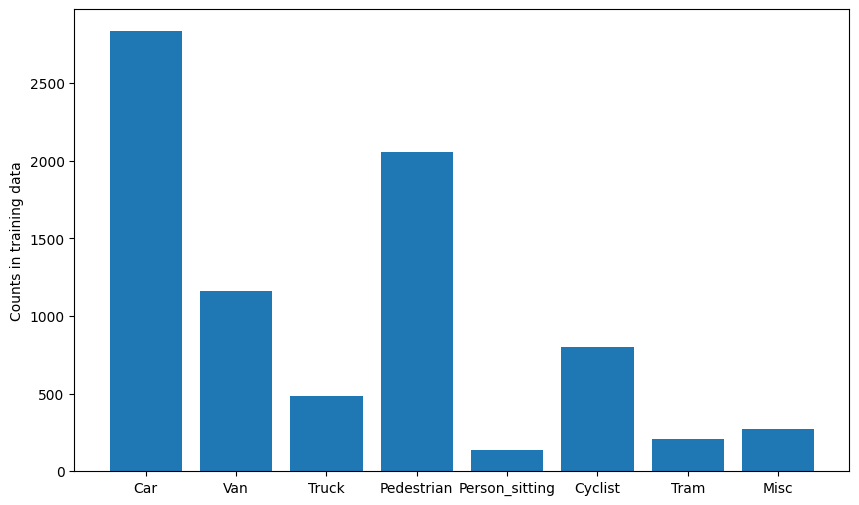

In [10]:
import matplotlib.pyplot as plt
# Visualizations will be shown in the notebook.
%matplotlib inline

labels = list(train_ds.map(lambda x,y: y).as_numpy_iterator())

classes, counts = np.unique(labels, return_counts=True)
plt.figure(figsize  = (10,6))
plt.ylabel('Counts in training data')
plt.bar(class_names, counts)

[libprotobuf ERROR external/com_google_protobuf/src/google/protobuf/text_format.cc:337] Error parsing text-format tensorflow.data.experimental.DistributedSnapshotMetadata: 1:1: Invalid control characters encountered in text.
[libprotobuf ERROR external/com_google_protobuf/src/google/protobuf/text_format.cc:337] Error parsing text-format tensorflow.data.experimental.DistributedSnapshotMetadata: 1:3: Expected identifier, got: 11218299070503871475
[libprotobuf ERROR external/com_google_protobuf/src/google/protobuf/text_format.cc:337] Error parsing text-format tensorflow.data.experimental.DistributedSnapshotMetadata: 1:1: Invalid control characters encountered in text.
[libprotobuf ERROR external/com_google_protobuf/src/google/protobuf/text_format.cc:337] Error parsing text-format tensorflow.data.experimental.DistributedSnapshotMetadata: 1:3: Expected identifier, got: 2750998057924106858
[libprotobuf ERROR external/com_google_protobuf/src/google/protobuf/text_format.cc:337] Error parsing t

<BarContainer object of 6 artists>

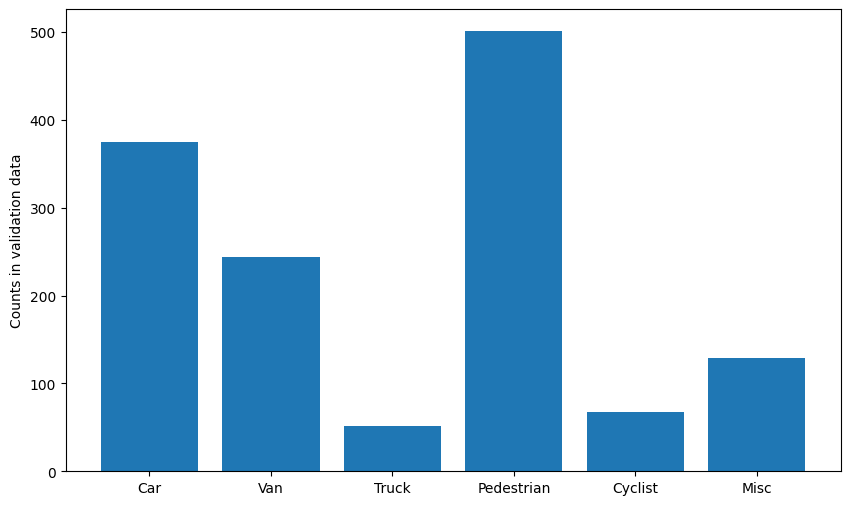

In [25]:
labels = list(valid_ds.map(lambda x,y: y).as_numpy_iterator())

classes, counts = np.unique(labels, return_counts=True)
plt.figure(figsize  = (10,6))
plt.ylabel('Counts in validation data')
plt.bar(class_names[classes], counts)

Load feature vector of `mobilenet-v2` from HUB, and freeze the weights, so they are not trained:

In [6]:
IMAGE_RES = 224

URL = "https://www.kaggle.com/models/google/mobilenet-v2/frameworks/TensorFlow2/variations/035-224-feature-vector/versions/2"
feature_extractor = hub.KerasLayer(URL, input_shape=(IMAGE_RES,IMAGE_RES,3))

feature_extractor.trainable = False


Compose a new model, using `mobilenet-v2` feature vector as a backbone and 8 kitti-classes as output layer:

In [27]:
# there are 8 classes in kitti dataset

# Add classification to the backbone
model = tf.keras.Sequential([
    feature_extractor,
    layers.Dense(NUM_CLASSES)
])

model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

Augment data in the dataset and form batches:

In [7]:
resizer_rescaler = keras_cv.layers.Augmenter(
    [
        # keras_cv.layers.Resizing(IMAGE_RES, IMAGE_RES, interpolation="bilinear"),
        keras_cv.layers.Rescaling(scale=1./255., offset=0.0)
    ],
)

augmenter = keras_cv.layers.Augmenter(
    [
        keras_cv.layers.RandomFlip(),
        keras_cv.layers.RandAugment(value_range=(0, 255))
    ],
)

def preprocess_data(image, label):
    image = resizer_rescaler(image)
    return image, label

def preprocess_augment_data(image, label):
    image = resizer_rescaler(image)
    image = augmenter(image)
    return image, label

Demonstration of data augmentation:

[libprotobuf ERROR external/com_google_protobuf/src/google/protobuf/text_format.cc:337] Error parsing text-format tensorflow.data.experimental.DistributedSnapshotMetadata: 1:1: Invalid control characters encountered in text.
[libprotobuf ERROR external/com_google_protobuf/src/google/protobuf/text_format.cc:337] Error parsing text-format tensorflow.data.experimental.DistributedSnapshotMetadata: 1:3: Expected identifier, got: 14569877308367710796
[libprotobuf ERROR external/com_google_protobuf/src/google/protobuf/text_format.cc:337] Error parsing text-format tensorflow.data.experimental.DistributedSnapshotMetadata: 1:1: Invalid control characters encountered in text.
[libprotobuf ERROR external/com_google_protobuf/src/google/protobuf/text_format.cc:337] Error parsing text-format tensorflow.data.experimental.DistributedSnapshotMetadata: 1:3: Expected identifier, got: 16615246193464866245
[libprotobuf ERROR external/com_google_protobuf/src/google/protobuf/text_format.cc:337] Error parsing 

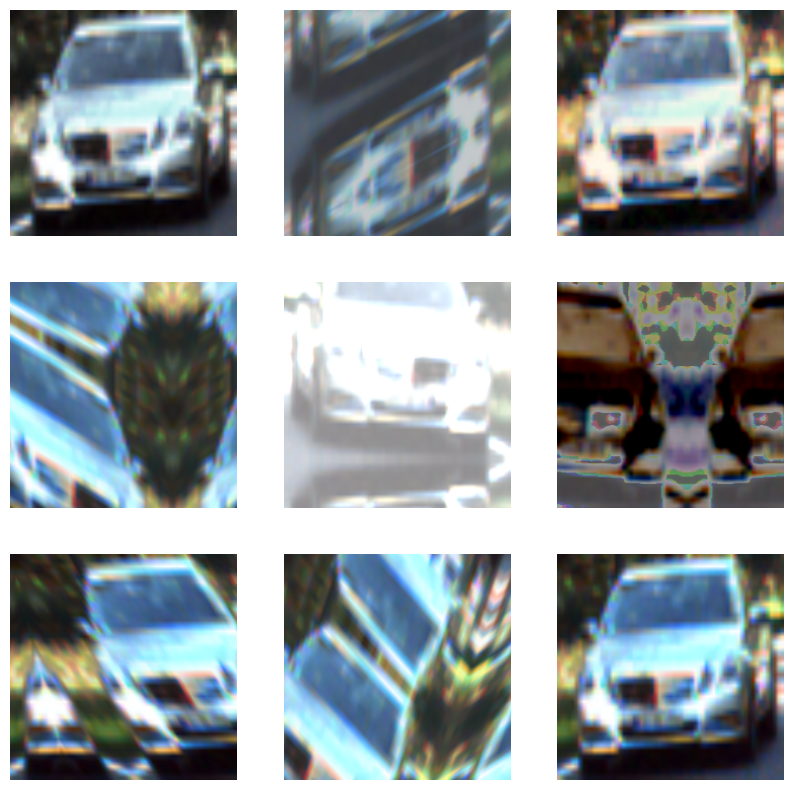

In [34]:
for elem in train_ds.take(1):
  plt.figure(figsize=(10, 10))
  first_image, l = elem
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    augmented_image = augmenter(tf.expand_dims(first_image, 0))
    plt.imshow(augmented_image[0] / 255)
    plt.axis('off')

In [8]:
BATCH_SIZE = 32

train_batches = train_ds.shuffle(len(train_ds)//4).map(preprocess_augment_data).batch(BATCH_SIZE).prefetch(1)
validation_batches = valid_ds.shuffle(len(valid_ds)//4).map(preprocess_data).batch(BATCH_SIZE).prefetch(1)

Train the model:

In [36]:
EPOCHS = 10

history = model.fit(train_batches,
                    epochs=EPOCHS,
                    validation_data=validation_batches)

[libprotobuf ERROR external/com_google_protobuf/src/google/protobuf/text_format.cc:337] Error parsing text-format tensorflow.data.experimental.DistributedSnapshotMetadata: 1:1: Invalid control characters encountered in text.
[libprotobuf ERROR external/com_google_protobuf/src/google/protobuf/text_format.cc:337] Error parsing text-format tensorflow.data.experimental.DistributedSnapshotMetadata: 1:3: Expected identifier, got: 11574766977734155708
[libprotobuf ERROR external/com_google_protobuf/src/google/protobuf/text_format.cc:337] Error parsing text-format tensorflow.data.experimental.DistributedSnapshotMetadata: 1:1: Invalid control characters encountered in text.
[libprotobuf ERROR external/com_google_protobuf/src/google/protobuf/text_format.cc:337] Error parsing text-format tensorflow.data.experimental.DistributedSnapshotMetadata: 1:3: Expected identifier, got: 6262922848886479712
[libprotobuf ERROR external/com_google_protobuf/src/google/protobuf/text_format.cc:337] Error parsing t

Epoch 1/10


2024-03-13 12:54:15.088011: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] Filling up shuffle buffer (this may take a while): 1511 of 1985
2024-03-13 12:54:17.578417: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] Shuffle buffer filled.
2024-03-13 12:54:18.257028: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8600
2024-03-13 12:54:18.739633: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-03-13 12:54:21.380606: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7eff539294e0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-03-13 12:54:21.380655: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce MX250, Compute Capability 6.1
2024-03-13 12:54:21.448802: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:255] disabling MLIR crash reproducer, set env v

249/249 [==============================] - ETA: 0s - loss: 1.5657 - accuracy: 0.4347

[libprotobuf ERROR external/com_google_protobuf/src/google/protobuf/text_format.cc:337] Error parsing text-format tensorflow.data.experimental.DistributedSnapshotMetadata: 1:1: Invalid control characters encountered in text.
[libprotobuf ERROR external/com_google_protobuf/src/google/protobuf/text_format.cc:337] Error parsing text-format tensorflow.data.experimental.DistributedSnapshotMetadata: 1:3: Expected identifier, got: 12898073615420743814
[libprotobuf ERROR external/com_google_protobuf/src/google/protobuf/text_format.cc:337] Error parsing text-format tensorflow.data.experimental.DistributedSnapshotMetadata: 1:1: Invalid control characters encountered in text.
[libprotobuf ERROR external/com_google_protobuf/src/google/protobuf/text_format.cc:337] Error parsing text-format tensorflow.data.experimental.DistributedSnapshotMetadata: 1:3: Expected identifier, got: 11218299070503871475
[libprotobuf ERROR external/com_google_protobuf/src/google/protobuf/text_format.cc:337] Error parsing 

249/249 [==============================] - 209s 761ms/step - loss: 1.5657 - accuracy: 0.4347 - val_loss: 0.9967 - val_accuracy: 0.6808
Epoch 2/10


2024-03-13 12:57:42.030017: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] Filling up shuffle buffer (this may take a while): 1144 of 1985
2024-03-13 12:57:48.526160: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] Shuffle buffer filled.


249/249 [==============================] - 286s 1s/step - loss: 1.4326 - accuracy: 0.4705 - val_loss: 0.9264 - val_accuracy: 0.7173
Epoch 3/10


2024-03-13 13:02:33.795975: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] Filling up shuffle buffer (this may take a while): 535 of 1985
2024-03-13 13:02:43.783839: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] Filling up shuffle buffer (this may take a while): 1628 of 1985
2024-03-13 13:02:46.179352: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] Shuffle buffer filled.


249/249 [==============================] - 291s 1s/step - loss: 1.4038 - accuracy: 0.4880 - val_loss: 0.9465 - val_accuracy: 0.6998
Epoch 4/10


2024-03-13 13:07:26.787633: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] Filling up shuffle buffer (this may take a while): 772 of 1985
2024-03-13 13:07:36.784262: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] Filling up shuffle buffer (this may take a while): 1483 of 1985
2024-03-13 13:07:44.859244: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] Shuffle buffer filled.


249/249 [==============================] - 336s 1s/step - loss: 1.3600 - accuracy: 0.5047 - val_loss: 0.9177 - val_accuracy: 0.7305
Epoch 5/10


2024-03-13 13:13:04.031839: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] Filling up shuffle buffer (this may take a while): 1235 of 1985
2024-03-13 13:13:10.608778: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] Shuffle buffer filled.


249/249 [==============================] - 314s 1s/step - loss: 1.3613 - accuracy: 0.4957 - val_loss: 0.8461 - val_accuracy: 0.7495
Epoch 6/10


2024-03-13 13:18:18.993047: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] Filling up shuffle buffer (this may take a while): 1222 of 1985
2024-03-13 13:18:26.891681: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] Shuffle buffer filled.


249/249 [==============================] - 324s 1s/step - loss: 1.3528 - accuracy: 0.5060 - val_loss: 0.8893 - val_accuracy: 0.7064
Epoch 7/10


2024-03-13 13:23:46.596784: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] Filling up shuffle buffer (this may take a while): 646 of 1985
2024-03-13 13:23:56.595685: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] Filling up shuffle buffer (this may take a while): 1580 of 1985
2024-03-13 13:24:00.431517: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] Shuffle buffer filled.


249/249 [==============================] - 338s 1s/step - loss: 1.3503 - accuracy: 0.5018 - val_loss: 0.9946 - val_accuracy: 0.6910
Epoch 8/10


2024-03-13 13:29:26.138737: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] Filling up shuffle buffer (this may take a while): 910 of 1985
2024-03-13 13:29:35.079831: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] Shuffle buffer filled.


249/249 [==============================] - 1141s 5s/step - loss: 1.3223 - accuracy: 0.5132 - val_loss: 0.7371 - val_accuracy: 0.7538
Epoch 9/10


2024-03-13 13:48:28.524206: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] Filling up shuffle buffer (this may take a while): 1194 of 1985
2024-03-13 13:48:34.700100: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] Shuffle buffer filled.


249/249 [==============================] - 290s 1s/step - loss: 1.3246 - accuracy: 0.5171 - val_loss: 0.7868 - val_accuracy: 0.7370
Epoch 10/10


2024-03-13 13:53:19.951650: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] Filling up shuffle buffer (this may take a while): 1174 of 1985
2024-03-13 13:53:27.014194: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] Shuffle buffer filled.


249/249 [==============================] - 320s 1s/step - loss: 1.3152 - accuracy: 0.5104 - val_loss: 0.9374 - val_accuracy: 0.6961


Plot training and validation accuracy and loss:

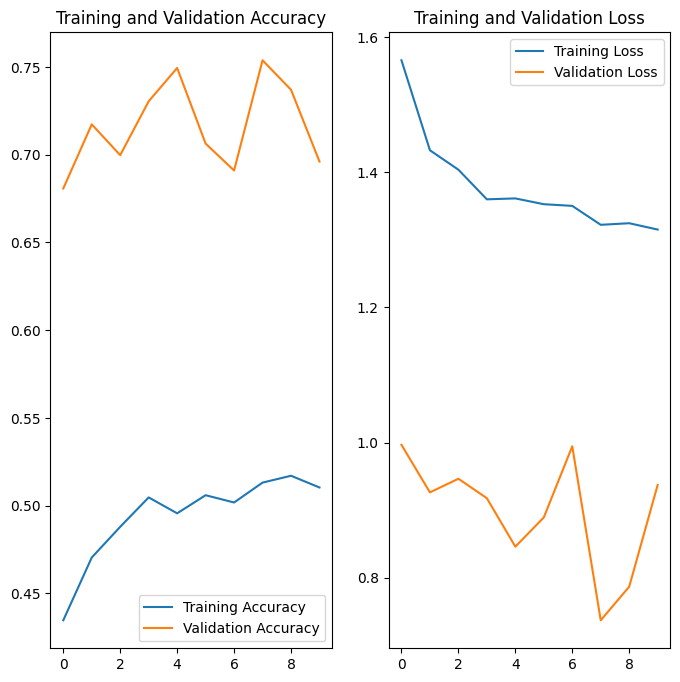

In [37]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(EPOCHS)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

Test this model's performance on new data using test dataset: 

In [38]:
test_batches = test_ds.shuffle(len(test_ds)//4).map(preprocess_data).batch(BATCH_SIZE).prefetch(1)

image_batch, label_batch = next(iter(test_batches.take(1)))
image_batch = image_batch.numpy()
label_batch = label_batch.numpy()

predicted_batch = model.predict(image_batch)
predicted_batch = tf.squeeze(predicted_batch).numpy()

predicted_ids = np.argmax(predicted_batch, axis=-1)
predicted_class_names = class_names[predicted_ids]
correct_class_names = class_names[label_batch]

# Print True Labels and Predicted Indices
print(predicted_ids)
print(label_batch)

[libprotobuf ERROR external/com_google_protobuf/src/google/protobuf/text_format.cc:337] Error parsing text-format tensorflow.data.experimental.DistributedSnapshotMetadata: 1:1: Invalid control characters encountered in text.
[libprotobuf ERROR external/com_google_protobuf/src/google/protobuf/text_format.cc:337] Error parsing text-format tensorflow.data.experimental.DistributedSnapshotMetadata: 1:3: Expected identifier, got: 14530369488529031680
[libprotobuf ERROR external/com_google_protobuf/src/google/protobuf/text_format.cc:337] Error parsing text-format tensorflow.data.experimental.DistributedSnapshotMetadata: 1:1: Invalid control characters encountered in text.
[libprotobuf ERROR external/com_google_protobuf/src/google/protobuf/text_format.cc:337] Error parsing text-format tensorflow.data.experimental.DistributedSnapshotMetadata: 1:3: Expected identifier, got: 17740259971104806135
[libprotobuf ERROR external/com_google_protobuf/src/google/protobuf/text_format.cc:337] Error parsing 

1/1 [==============================] - 2s 2s/step
[2 1 1 1 1 0 5 0 1 5 0 0 1 6 0 0 0 1 0 7 2 1 2 0 0 3 0 1 0 1 0 6]
[5 7 7 7 1 0 3 0 1 3 0 1 7 6 0 0 0 1 0 7 7 1 1 0 0 3 0 7 0 1 1 6]


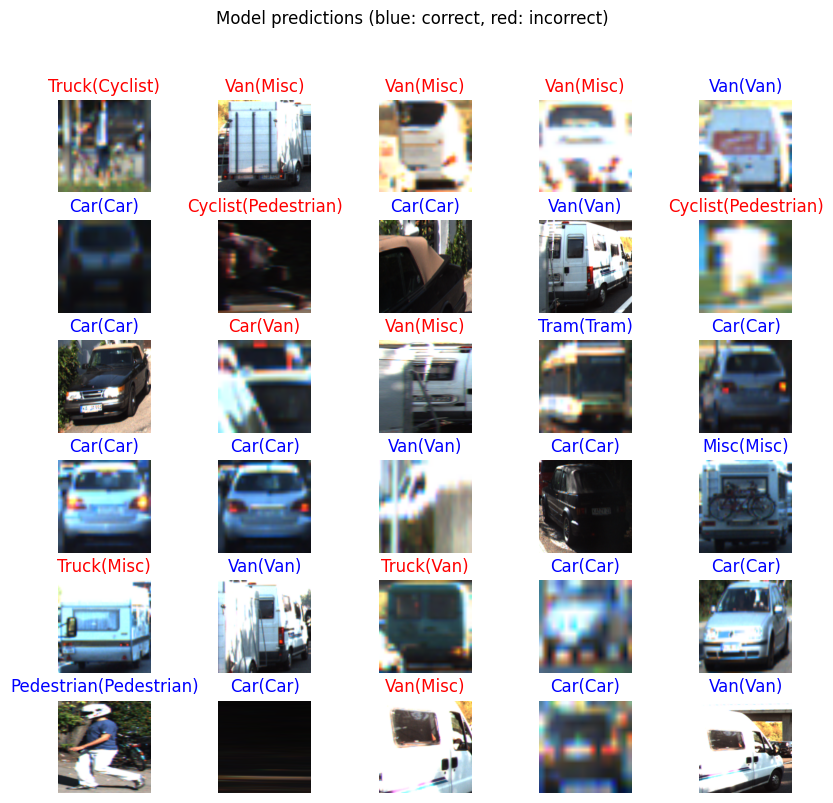

In [39]:
# Plot Model Predictions
plt.figure(figsize=(10,9))
for n in range(30):
  plt.subplot(6,5,n+1)
  plt.subplots_adjust(hspace = 0.3)
  plt.imshow(image_batch[n])
  color = "blue" if predicted_ids[n] == label_batch[n] else "red"
  plt.title(predicted_class_names[n].title() + '('+correct_class_names[n].title()+')', color=color)
  plt.axis('off')
_ = plt.suptitle("Model predictions (blue: correct, red: incorrect)")

Continue training the model:

In [40]:
ADD_EPOCHS = 10
TOTAL_EPOCHS =  EPOCHS + ADD_EPOCHS

history_fine = model.fit(train_batches,
                         epochs=TOTAL_EPOCHS,
                         initial_epoch=history.epoch[-1],
                         validation_data=validation_batches)

Epoch 10/20


2024-03-13 14:03:48.331974: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] Filling up shuffle buffer (this may take a while): 1902 of 1985
2024-03-13 14:03:48.827175: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] Shuffle buffer filled.


249/249 [==============================] - 219s 837ms/step - loss: 1.3190 - accuracy: 0.5182 - val_loss: 0.8326 - val_accuracy: 0.7509
Epoch 11/20


2024-03-13 14:07:28.539024: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] Filling up shuffle buffer (this may take a while): 964 of 1985
2024-03-13 14:07:36.494819: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] Shuffle buffer filled.


249/249 [==============================] - 298s 1s/step - loss: 1.3211 - accuracy: 0.5128 - val_loss: 0.8659 - val_accuracy: 0.7575
Epoch 12/20


2024-03-13 14:12:27.443805: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] Filling up shuffle buffer (this may take a while): 1132 of 1985
2024-03-13 14:12:34.338834: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] Shuffle buffer filled.


249/249 [==============================] - 335s 1s/step - loss: 1.2960 - accuracy: 0.5208 - val_loss: 0.8187 - val_accuracy: 0.7502
Epoch 13/20


2024-03-13 14:18:03.784487: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] Filling up shuffle buffer (this may take a while): 937 of 1985
2024-03-13 14:18:12.461767: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] Shuffle buffer filled.


249/249 [==============================] - 335s 1s/step - loss: 1.2868 - accuracy: 0.5307 - val_loss: 0.8278 - val_accuracy: 0.7465
Epoch 14/20


2024-03-13 14:23:40.123808: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] Filling up shuffle buffer (this may take a while): 874 of 1985
2024-03-13 14:23:50.112041: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] Filling up shuffle buffer (this may take a while): 1866 of 1985
2024-03-13 14:23:51.026090: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] Shuffle buffer filled.


249/249 [==============================] - 330s 1s/step - loss: 1.3008 - accuracy: 0.5193 - val_loss: 0.8565 - val_accuracy: 0.7305
Epoch 15/20


2024-03-13 14:29:11.638396: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] Filling up shuffle buffer (this may take a while): 835 of 1985
2024-03-13 14:29:21.197704: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] Shuffle buffer filled.


249/249 [==============================] - 339s 1s/step - loss: 1.2933 - accuracy: 0.5210 - val_loss: 0.8387 - val_accuracy: 0.7407
Epoch 16/20


2024-03-13 14:34:51.587897: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] Filling up shuffle buffer (this may take a while): 951 of 1985
2024-03-13 14:34:59.520811: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] Shuffle buffer filled.


249/249 [==============================] - 320s 1s/step - loss: 1.2930 - accuracy: 0.5327 - val_loss: 0.8858 - val_accuracy: 0.7275
Epoch 17/20


2024-03-13 14:40:13.438636: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] Filling up shuffle buffer (this may take a while): 865 of 1985
2024-03-13 14:40:22.208908: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] Shuffle buffer filled.


249/249 [==============================] - 319s 1s/step - loss: 1.2795 - accuracy: 0.5305 - val_loss: 0.8304 - val_accuracy: 0.7560
Epoch 18/20


2024-03-13 14:45:34.103906: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] Filling up shuffle buffer (this may take a while): 961 of 1985
2024-03-13 14:45:43.692622: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] Shuffle buffer filled.


249/249 [==============================] - 320s 1s/step - loss: 1.2921 - accuracy: 0.5304 - val_loss: 0.8072 - val_accuracy: 0.7524
Epoch 19/20


2024-03-13 14:50:54.858240: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] Filling up shuffle buffer (this may take a while): 1144 of 1985
2024-03-13 14:51:01.698127: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] Shuffle buffer filled.


249/249 [==============================] - 323s 1s/step - loss: 1.2874 - accuracy: 0.5298 - val_loss: 0.9425 - val_accuracy: 0.7392
Epoch 20/20


2024-03-13 14:56:19.477159: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] Filling up shuffle buffer (this may take a while): 1050 of 1985
2024-03-13 14:56:26.801634: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] Shuffle buffer filled.


249/249 [==============================] - 324s 1s/step - loss: 1.2801 - accuracy: 0.5302 - val_loss: 0.7934 - val_accuracy: 0.7589


In [41]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

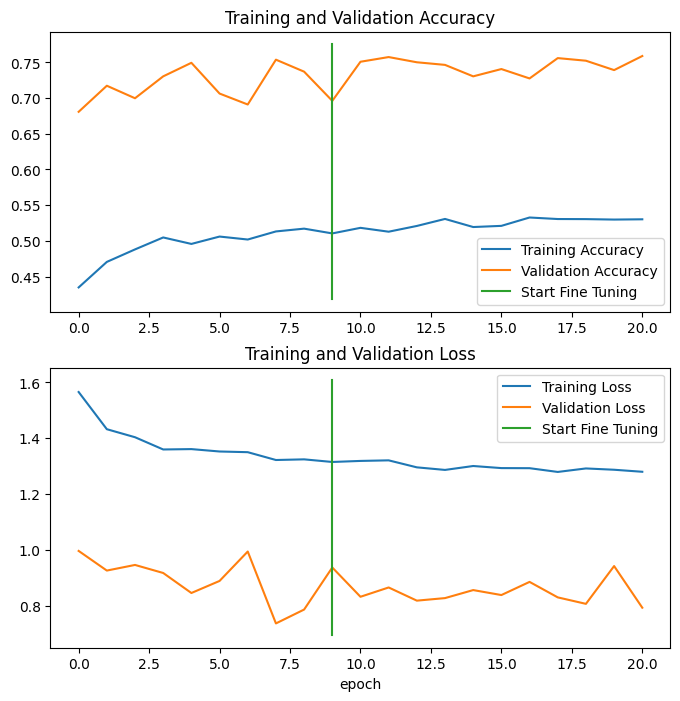

In [42]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
#plt.ylim([0.8, 1])
plt.plot([EPOCHS-1,EPOCHS-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
#plt.ylim([0, 1.0])
plt.plot([EPOCHS-1,EPOCHS-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [9]:
model2 = tf.keras.Sequential([
    feature_extractor,
    layers.Dense(NUM_CLASSES)
])

model2.compile(
    optimizer=tf.keras.optimizers.SGD(learning_rate=0.01),

    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

In [11]:
EPOCHS = 10
history2 = model2.fit(train_batches,
                    epochs=EPOCHS,
                    validation_data=validation_batches)

[libprotobuf ERROR external/com_google_protobuf/src/google/protobuf/text_format.cc:337] Error parsing text-format tensorflow.data.experimental.DistributedSnapshotMetadata: 1:1: Invalid control characters encountered in text.
[libprotobuf ERROR external/com_google_protobuf/src/google/protobuf/text_format.cc:337] Error parsing text-format tensorflow.data.experimental.DistributedSnapshotMetadata: 1:3: Expected identifier, got: 13855399524005425149
[libprotobuf ERROR external/com_google_protobuf/src/google/protobuf/text_format.cc:337] Error parsing text-format tensorflow.data.experimental.DistributedSnapshotMetadata: 1:1: Invalid control characters encountered in text.
[libprotobuf ERROR external/com_google_protobuf/src/google/protobuf/text_format.cc:337] Error parsing text-format tensorflow.data.experimental.DistributedSnapshotMetadata: 1:3: Expected identifier, got: 12572638906097864597
[libprotobuf ERROR external/com_google_protobuf/src/google/protobuf/text_format.cc:337] Error parsing 

Epoch 1/10


2024-03-13 15:22:02.194622: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] Filling up shuffle buffer (this may take a while): 1829 of 1985
2024-03-13 15:22:03.111441: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] Shuffle buffer filled.
2024-03-13 15:22:04.021320: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8600
2024-03-13 15:22:04.864673: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-03-13 15:22:07.883765: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7f13a44e7e40 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-03-13 15:22:07.883836: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce MX250, Compute Capability 6.1
2024-03-13 15:22:08.244425: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or direct

249/249 [==============================] - ETA: 0s - loss: 1.6499 - accuracy: 0.4007

[libprotobuf ERROR external/com_google_protobuf/src/google/protobuf/text_format.cc:337] Error parsing text-format tensorflow.data.experimental.DistributedSnapshotMetadata: 1:1: Invalid control characters encountered in text.
[libprotobuf ERROR external/com_google_protobuf/src/google/protobuf/text_format.cc:337] Error parsing text-format tensorflow.data.experimental.DistributedSnapshotMetadata: 1:3: Expected identifier, got: 4210223412227514104
[libprotobuf ERROR external/com_google_protobuf/src/google/protobuf/text_format.cc:337] Error parsing text-format tensorflow.data.experimental.DistributedSnapshotMetadata: 1:1: Invalid control characters encountered in text.
[libprotobuf ERROR external/com_google_protobuf/src/google/protobuf/text_format.cc:337] Error parsing text-format tensorflow.data.experimental.DistributedSnapshotMetadata: 1:3: Expected identifier, got: 2750998057924106858
[libprotobuf ERROR external/com_google_protobuf/src/google/protobuf/text_format.cc:337] Error parsing te

249/249 [==============================] - 275s 1s/step - loss: 1.6499 - accuracy: 0.4007 - val_loss: 1.1874 - val_accuracy: 0.6399
Epoch 2/10


2024-03-13 15:26:34.515863: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] Filling up shuffle buffer (this may take a while): 792 of 1985
2024-03-13 15:26:44.512084: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] Filling up shuffle buffer (this may take a while): 1647 of 1985
2024-03-13 15:26:46.644773: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] Shuffle buffer filled.


249/249 [==============================] - ETA: 0s - loss: 1.5215 - accuracy: 0.4458

2024-03-13 15:32:24.668186: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] Filling up shuffle buffer (this may take a while): 174 of 342
2024-03-13 15:32:32.729396: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] Shuffle buffer filled.


249/249 [==============================] - 400s 2s/step - loss: 1.5215 - accuracy: 0.4458 - val_loss: 1.0376 - val_accuracy: 0.7012
Epoch 3/10


2024-03-13 15:33:18.271667: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] Filling up shuffle buffer (this may take a while): 626 of 1985
2024-03-13 15:33:28.265637: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] Filling up shuffle buffer (this may take a while): 1404 of 1985
2024-03-13 15:33:32.858577: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] Shuffle buffer filled.


249/249 [==============================] - 327s 1s/step - loss: 1.4589 - accuracy: 0.4707 - val_loss: 1.1334 - val_accuracy: 0.6523
Epoch 4/10


2024-03-13 15:38:46.791157: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] Filling up shuffle buffer (this may take a while): 1010 of 1985
2024-03-13 15:38:54.964743: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] Shuffle buffer filled.


249/249 [==============================] - 328s 1s/step - loss: 1.4449 - accuracy: 0.4736 - val_loss: 0.9247 - val_accuracy: 0.7297
Epoch 5/10


2024-03-13 15:44:18.178600: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] Filling up shuffle buffer (this may take a while): 505 of 1985
2024-03-13 15:44:26.533758: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] Filling up shuffle buffer (this may take a while): 1515 of 1985
2024-03-13 15:44:29.628616: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] Shuffle buffer filled.


249/249 [==============================] - 287s 1s/step - loss: 1.4291 - accuracy: 0.4768 - val_loss: 1.0074 - val_accuracy: 0.6917
Epoch 6/10


2024-03-13 15:49:04.856573: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] Filling up shuffle buffer (this may take a while): 1124 of 1985
2024-03-13 15:49:10.562726: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] Shuffle buffer filled.


249/249 [==============================] - 269s 1s/step - loss: 1.4171 - accuracy: 0.4782 - val_loss: 0.9278 - val_accuracy: 0.7385
Epoch 7/10


2024-03-13 15:53:34.952449: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] Filling up shuffle buffer (this may take a while): 1347 of 1985
2024-03-13 15:53:39.014334: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] Shuffle buffer filled.


249/249 [==============================] - 267s 1s/step - loss: 1.3993 - accuracy: 0.4828 - val_loss: 0.9400 - val_accuracy: 0.7246
Epoch 8/10


2024-03-13 15:58:04.817927: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] Filling up shuffle buffer (this may take a while): 942 of 1985
2024-03-13 15:58:14.814683: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] Filling up shuffle buffer (this may take a while): 1972 of 1985
2024-03-13 15:58:15.217905: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] Shuffle buffer filled.


249/249 [==============================] - 297s 1s/step - loss: 1.3962 - accuracy: 0.4878 - val_loss: 0.9063 - val_accuracy: 0.7407
Epoch 9/10


2024-03-13 16:03:02.895671: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] Filling up shuffle buffer (this may take a while): 1284 of 1985
2024-03-13 16:03:07.562115: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] Shuffle buffer filled.


249/249 [==============================] - 252s 953ms/step - loss: 1.3806 - accuracy: 0.4931 - val_loss: 0.9476 - val_accuracy: 0.7137
Epoch 10/10


2024-03-13 16:07:16.104711: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] Filling up shuffle buffer (this may take a while): 1351 of 1985
2024-03-13 16:07:20.041375: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] Shuffle buffer filled.


249/249 [==============================] - 248s 940ms/step - loss: 1.3800 - accuracy: 0.4933 - val_loss: 0.8466 - val_accuracy: 0.7473


In [13]:
model2.save(os.path.join(os.getcwd(), "models", "model_sgd.keras"))